# The k-armed Bandit Problem
Imagine a slot machine with k different levers (actions) to choose from, each one of those levers has an expected reward given that that action is selected. The problem is that we do not know what's the true value of each action, but would like to act in such a manner as to maximize the accumulated rewards over time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class KArmedBandit:
    def __init__(self, k):
        self.arms = []
        means = np.random.normal(size=k, loc=0, scale=1)
        self.optimal_action = np.argmax(means) # for statistics
        for i in range(k):
            self.arms.append((means[i], 1))
            
    def pull(self, action):
        mu, sigma = self.arms[action]
        return np.random.normal(mu, sigma)

## Action-value methods
Action-value methods create a mapping from action to the estimated value for that action.

### Sample average
It is effectively the mean of all the rewards received so far for an action $a$. The following is the incremental version that saves computation time and memory.

$Q_{n+1}(a) = Q_n(a) + \frac{1}{n} [R_n - Q_n(a)]$

### Exponential recency-weighted average
Uses a fixed value $\alpha$ to favor more recent rewards, in contrast with $\frac{1}{n}$ which takes all rewards equally into account. 

$Q_{n+1}(a) = Q_n(a) + \alpha [R_n - Q_n(a)]$

## Action selection
Action selection is important to balance the exploration vs. exploitation dynamic. Exploration is useful to discover which action is truly optimal whereas exploitation makes use of the current knowledge to maximize reward.
### $\epsilon$-greedy
With probability $\epsilon$, selects a random action, otherwise selects the greedy action defined as:

$A_t = \underset{a}{argmax} Q_t(a)$

### Upper-Confidence-Bound Action Selection
$A_t = \underset{a}{argmax} [Q_t(a) + c \sqrt(\frac{\ln t}{N_t(a)})]$

If $N_t(a) = 0$ then $a$ is considered a maximizing action.

## Gradient Bandit Algorithms
Gradient bandit algorithms actually learn a numerical preference for each action instead of the action's expected value, and chooses the action with probability $\pi_t(a)$ that follows a soft-max distribution

$Pr\{A_t = a\} = \frac{e^{H_t(a)}}{\sum_{b=1}^{k} e^{H_t(b)}} = \pi_t(a)$

The numeric preference $H_t(a)$ update is defined as: 

$H_{t+1}(A_t) = H_{t}(A_t) + \alpha (R_t - \bar{R}_t)(1 - \pi_t(A_t))$, and

$H_{t+1}(a) = H_{t}(a) - \alpha (R_t - \bar{R}_t)\pi_t(a)$, for all $a \neq A_t$

where $\bar{R}_t$ is an average of all rewards received up until time t 


In [3]:
# Action Value Methods
class SampleAverage:    
    def __init__(self, k):
        self.n = np.zeros(k)
        
    def action_count(self):
        return self.n
        
    def __call__(self, q, action, reward):
        self.n[action] += 1
        current_estimate = q[action]
        q[action] = current_estimate + (1 / self.n[action]) * (reward - current_estimate)
        return q
    
class ExponentialRecencyWeightedAverage:
    def __init__(self, alpha):
        self.alpha = alpha
        
    def __call__(self, q, action, reward):
        current_estimate = q[action]
        q[action] = current_estimate + alpha * (reward - current_estimate)
        return q


# Action Selection
class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon
    
    def __call__(self, q):
        # Sample random action
        if np.random.uniform() < self.epsilon:
            return np.random.randint(0, k)
        # Sample from best actions
        else:
            return np.random.choice(np.argwhere(q == np.max(q)).flatten())
        
class UCB:
    def __init__(self, c, k):
        self.c = c
        self.n = np.zeros(k, dtype=np.int)
        
    def __call__(self, q):
        not_taken = np.argwhere(self.n == 0).flatten()
        if np.any(not_taken):
            action = not_taken[0]
            self.n[action] += 1
            return action
        
        t = np.sum(self.n) + 1
        action = np.argmax(q + c * np.sqrt(np.log(t)/self.n))
        self.n[action] += 1
        return action
        
        
# Gradient Bandit        
class GradientBandit:
    def __init__(self, k, alpha=0.1, weighted_average = False):
        self.k = k
        self.alpha = alpha
        self.probabilities = [self.softmax(np.zeros(k), a) for a in range(k)]
        self.avg_reward = 0
        self.n = 0        
        if weighted_average:
            self.update_average = lambda r: self.avg_reward + self.alpha * (r - self.avg_reward)
        else:
            self.update_average = lambda r: self.avg_reward + (1 / self.n) * (r - self.avg_reward)
        
    def softmax(self, h, action):
        return np.exp(h[action]) / np.sum(np.exp(h))
    
    def sample_action(self, h):
        # Use this function as action selector
        self.probabilities = [self.softmax(h, a) for a in range(self.k)]
        
        return np.random.choice(self.k, p=self.probabilities)
    
    def __call__(self, h, action, reward):
        for a, _ in enumerate(h):
            if a == action:
                h[a] = h[a] + self.alpha * (reward - self.avg_reward) * (1 - self.probabilities[a])
            else:
                h[a] = h[a] - self.alpha * (reward - self.avg_reward) * self.probabilities[a]
        
        self.n += 1
        self.avg_reward = self.update_average(reward)
        
        return h        
        

# Testbed

[Text(0.5, 0, 'Steps'), Text(0, 0.5, '% Optimal Action'), (0.0, 100.0)]

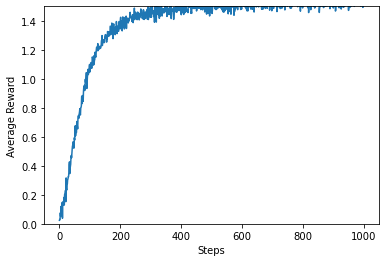

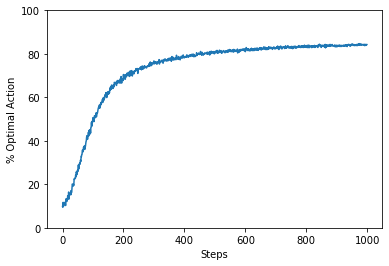

In [4]:
# Parameters to play with
k = 10
epsilon = 0.1
alpha = 0.1
c = 2
runs = 2000
steps = 1000

history = {
    'reward': np.zeros((runs, steps)),
    'optimal_action': np.zeros((runs, steps))
}

for run in range(runs):
    # Initialize a new test
    bandit = KArmedBandit(k)
    update_rule = GradientBandit(k, alpha)
    action_selector = update_rule.sample_action
    q = np.zeros(k)    
    
    # Loop
    for step in range(steps):
        action = action_selector(q)
        
        reward = bandit.pull(action)

        q = update_rule(q, action, reward)

        history['reward'][run, step] = reward
        history['optimal_action'][run, step] = action == bandit.optimal_action # for statistics

# Summarize
avg_reward = np.sum(history['reward'], 0) / runs
optimal_action_percent = np.sum(history['optimal_action'], 0) * 100 / runs

# Plot average Rewards
fig, ax = plt.subplots()
ax.plot(np.arange(steps), avg_reward)
ax.set(xlabel='Steps', ylabel='Average Reward', ylim=(0, 1.5))

# Plot % Optimal Action
fig, ax = plt.subplots()
ax.plot(np.arange(steps), optimal_action_percent)
ax.set(xlabel='Steps', ylabel='% Optimal Action', ylim=(0, 100))